# Reaching a statistically steady state

In this notebook, I analyse a long, low-resolution spin-up simulation to determine:
- Whether the flow reaches a statistically steady state, and how long it takes to do so,
- Roughly how long I will need to run subsequent simulations (starting from the final state of this one) to reduce the uncertainties in time-averaged quantities to acceptable levels, and
- The frequency at which I will need to save the model state in order to obtain accurate time averages -- saving the state too frequently will waste storage space, but if it is saved too infrequently, the mean of the samples will no longer be a good approximation to the true time average.

To this end, I examine the time evolution of four global quantities:
- Vertically averaged Nusselt number,
- RMS speed,
- Spatially averaged kinetic energy dissipation rate, and
- Spatially averaged thermal energy dissipation rate.

**Table of contents**<a id='toc0_'></a>    
- [Data](#toc1_)    
- [Nusselt number](#toc2_)    
- [RMS speed](#toc3_)    
- [Kinetic energy dissipation rate](#toc4_)    
- [Thermal energy dissipation rate](#toc5_)    
- [Estimating required simulation time](#toc6_)    
- [Checking the output frequency](#toc7_)    
- [Conclusions](#toc8_)    
- [Next steps](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [149]:
import importlib

import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client

from modules import stats
importlib.reload(stats)

<module 'modules.stats' from '/srv/ccrc/AtmSS/z5310829/honours_project/modules/stats.py'>

In [5]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='8GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45545,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:41277,Total threads: 1
Dashboard: http://127.0.0.1:42995/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:36797,


## <a id='toc1_'></a>[Data](#toc0_)
The spin-up simulation has the following parameters:
- $N_x, N_z, \Gamma = 256, 128, 8$
- $\Delta t = 0.005$
- Simulation time 1000 units
- Output frequency: 0.2 time units
- $\mathrm{Ra} = 10^9$
- $\mathrm{Pr} = 1$
- Hyperdiffusivity $\nu^* = 10^{-3}$

In [6]:
data = xr.open_mfdataset('../data/spin_up/*.nc')
rayleigh = 1e9
prandtl = 1

## <a id='toc2_'></a>[Nusselt number](#toc0_)

In [105]:
nusselt = stats.nusselt_number(data, rayleigh, prandtl).compute()

[(-5.0, 5.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Percentage change in 100 time unit rolling mean')]

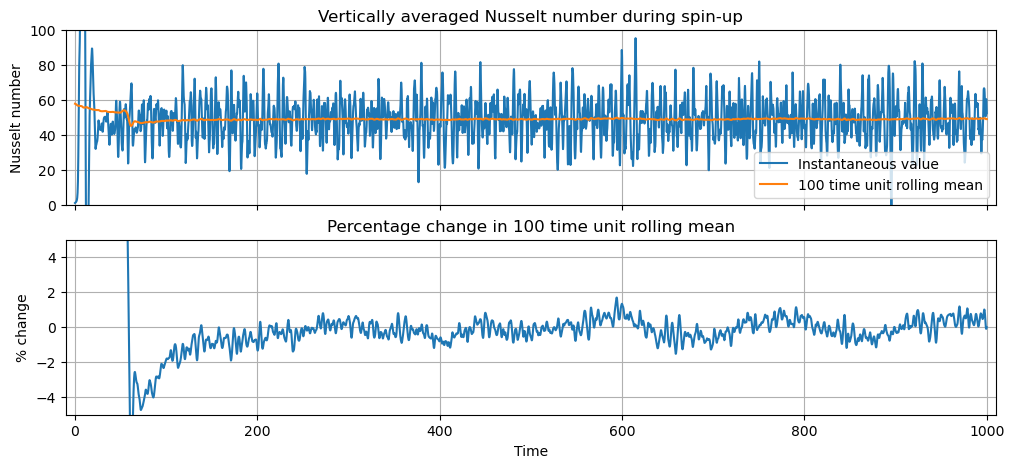

In [102]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

interval = (data.t[1] - data.t[0]).item()
window = round(100/interval) + 1
mean = nusselt.rolling(t=window, center=True, min_periods=window//2).mean()

axes[0].plot(nusselt.t, nusselt, label='Instantaneous value')
axes[0].plot(mean.t, mean, label='100 time unit rolling mean')
axes[0].grid()
axes[0].legend()
axes[0].set(
    ylim=(0, 100), xlim=(-10, 1010), ylabel='Nusselt number',
    title='Vertically averaged Nusselt number during spin-up'    
)

axes[1].plot(mean.t, (mean/mean[~mean.isnull()].isel(t=-1) - 1)*1e2)
axes[1].grid()
axes[1].set(
    ylim=(-5, 5), xlabel='Time', ylabel=r'% change',
    title='Percentage change in 100 time unit rolling mean'
)

The Nusselt number exhibits high-amplitude oscillations, but is seen to reach a statistically steady state if averaged over a long enough window. There are also much slower oscillations in the 100-time-unit rolling mean (period ~ 100 units) with amplitude ~ 1% of the mean value.

## <a id='toc3_'></a>[RMS speed](#toc0_)

In [106]:
rms_speed = stats.rms_speed(data).compute()

[Text(0, 0.5, '% change')]

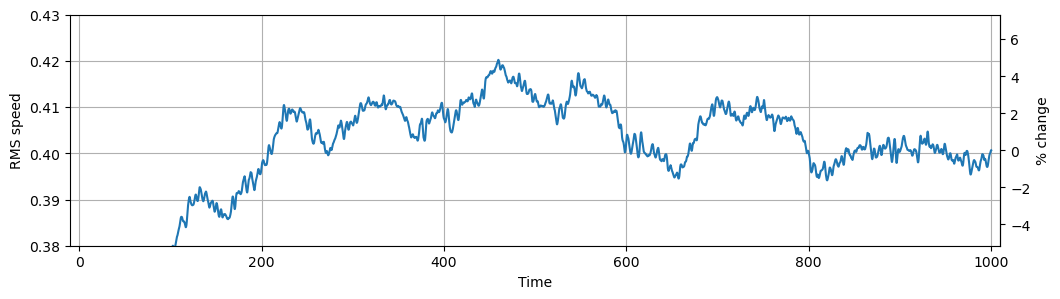

In [117]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(rms_speed.t, rms_speed)
ax.grid()
ax.set(ylim=(0.38, 0.43), xlim=(-10, 1010), ylabel='RMS speed', xlabel='Time')

ref = rms_speed.isel(t=-1).item()
sec_ax = ax.secondary_yaxis(
    'right',
    functions=(lambda x: (x/ref - 1)*1e2, lambda x: (x/1e2 + 1)*ref),
)
sec_ax.set(ylabel=r'% change')

The RMS speed is much less noisy on short time scales, but has slow oscillations with over several percent of the mean value.

## <a id='toc4_'></a>[Kinetic energy dissipation rate](#toc0_)

In [119]:
eps_k = stats.kinetic_dissipation(data, rayleigh, prandtl).compute()

[(-5.0, 5.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Percentage change in 100 time unit rolling mean')]

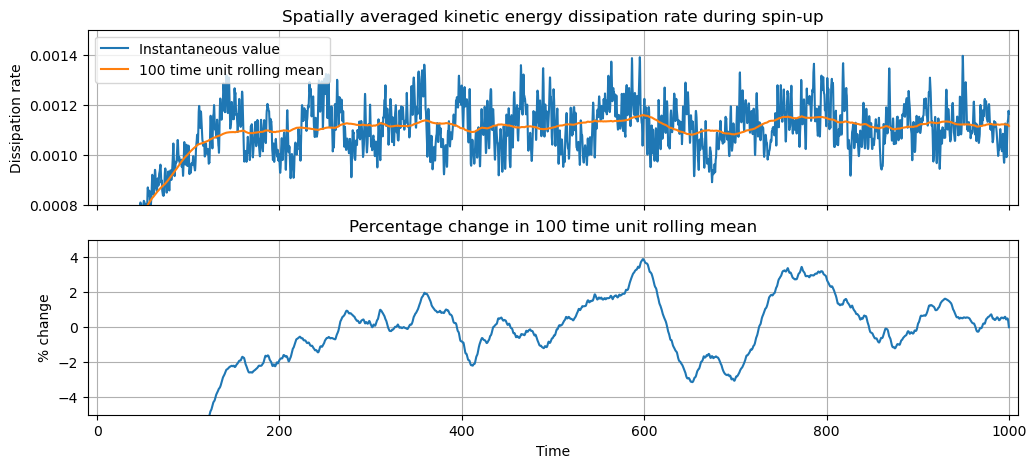

In [128]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

interval = (data.t[1] - data.t[0]).item()
window = round(100/interval) + 1
mean = eps_k.rolling(t=window, center=True, min_periods=window//2).mean()

axes[0].plot(eps_k.t, eps_k, label='Instantaneous value')
axes[0].plot(mean.t, mean, label='100 time unit rolling mean')
axes[0].grid()
axes[0].legend()
axes[0].set(
    ylim=(0.8e-3, 1.5e-3), xlim=(-10, 1010), ylabel='Dissipation rate',
    title='Spatially averaged kinetic energy dissipation rate during spin-up'    
)

axes[1].plot(mean.t, (mean/mean[~mean.isnull()].isel(t=-1) - 1)*1e2)
axes[1].grid()
axes[1].set(
    ylim=(-5, 5), xlabel='Time', ylabel=r'% change',
    title='Percentage change in 100 time unit rolling mean'
)

The kinetic dissipation rate has both fast and slow oscillations of similar amplitude about its mean value. 

## <a id='toc5_'></a>[Thermal energy dissipation rate](#toc0_)

In [131]:
eps_T = stats.thermal_dissipation(data, rayleigh, prandtl).compute()

[(-5.0, 5.0),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, '% change'),
 Text(0.5, 1.0, 'Percentage change in 100 time unit rolling mean')]

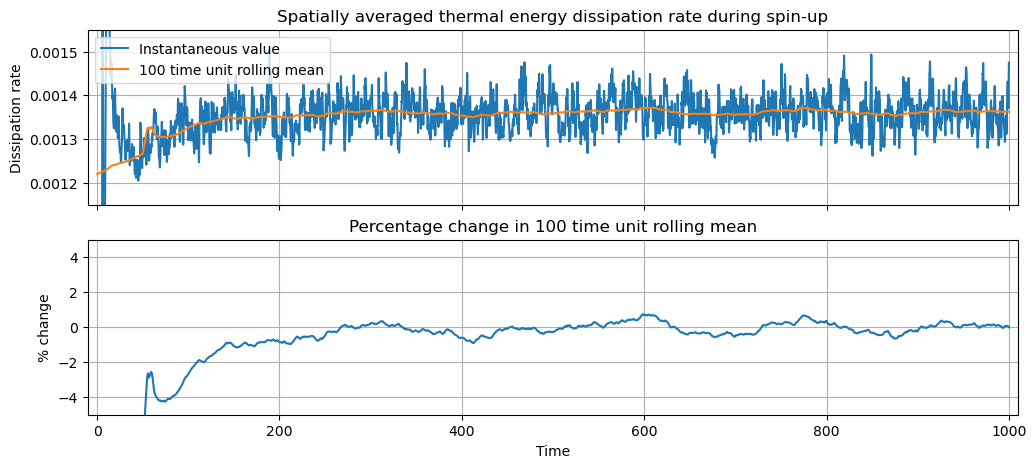

In [138]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

interval = (data.t[1] - data.t[0]).item()
window = round(100/interval) + 1
mean = eps_T.rolling(t=window, center=True, min_periods=window//2).mean()

axes[0].plot(eps_T.t, eps_T, label='Instantaneous value')
axes[0].plot(mean.t, mean, label='100 time unit rolling mean')
axes[0].grid()
axes[0].legend(loc='upper left')
axes[0].set(
    ylim=(1.15e-3, 1.55e-3), xlim=(-10, 1010), ylabel='Dissipation rate',
    title='Spatially averaged thermal energy dissipation rate during spin-up'    
)

axes[1].plot(mean.t, (mean/mean[~mean.isnull()].isel(t=-1) - 1)*1e2)
axes[1].grid()
axes[1].set(
    ylim=(-5, 5), xlabel='Time', ylabel=r'% change',
    title='Percentage change in 100 time unit rolling mean'
)

The thermal dissipation rate is perhaps the most well-behaved quantity because its fast and slow oscillations both have small relative amplitude. This results in a much more stable rolling mean.

## <a id='toc6_'></a>[Estimating required simulation time](#toc0_)

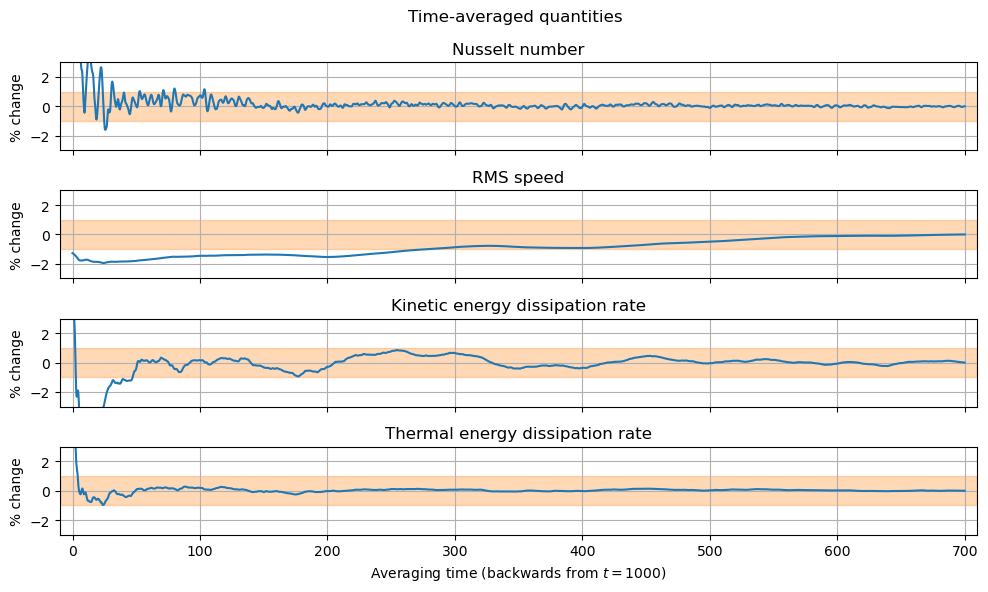

In [163]:
t_max = 700.
metrics = {
    'Nusselt number': nusselt,
    'RMS speed': rms_speed,
    'Kinetic energy dissipation rate': eps_k,
    'Thermal energy dissipation rate': eps_T,
}
fig, axes = plt.subplots(
    len(metrics), 1, figsize=(10, 1.5*len(metrics)), sharex=True)

for i, m in enumerate(metrics):
    mean = stats.reverse_running_mean(metrics[m], 't')
    mean = mean[mean.t <= t_max]
    axes[i].plot(mean.t, (mean/mean.isel(t=-1) - 1)*1e2)
    axes[i].fill_between(
        axes[i].get_xlim(), -1, 1, color='tab:orange', alpha=0.3)
    axes[i].grid()
    axes[i].set(
        ylabel=r'% change', title=m,
        ylim=(-3, 3), xlim=(-10, t_max + 10)
    )

axes[-1].set(xlabel=f'Averaging time (backwards from $t={data.t.max():.0f}$)')
fig.suptitle('Time-averaged quantities', x=0.52)
fig.tight_layout()

- All except the RMS speed exhibit fast oscillations, which are easily removed by averaging over at most ~ 50 time units (for a 1% uncertainty threshold).
- The RMS speed and kinetic dissipation rate have lower-frequency components that require averaging over at least ~300 time units if a 1% uncertainty is to be achieved.

## <a id='toc7_'></a>[Checking the output frequency](#toc0_)

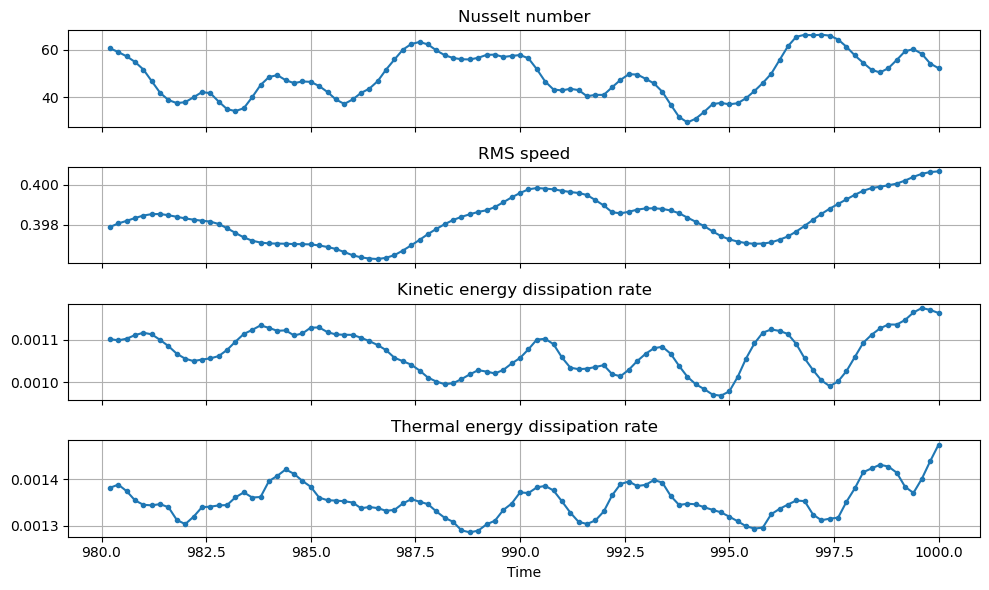

In [168]:
mask = data.t > 980
fig, axes = plt.subplots(
    len(metrics), 1, figsize=(10, 1.5*len(metrics)), sharex=True)

for i, m in enumerate(metrics):
    da = metrics[m].isel(t=mask)
    axes[i].plot(da.t, da, '.-')
    axes[i].grid()
    axes[i].set(title=m)

axes[-1].set(xlabel='Time')
fig.tight_layout()

The time series of are all smooth, so saving the model state every 0.2 time units is sufficient to accurately sample the four metrics, given the frequencies of their fastest oscillations.

## <a id='toc8_'></a>[Conclusions](#toc0_)
- All four quantities appear to reach a statistically steady state after approximately 300 time units.
- All except the RMS speed exhibit fast oscillations, which are easily removed by averaging over at most ~ 50 time units (for a 1% uncertainty threshold).
- The RMS speed and kinetic dissipation rate have lower-frequency components that require averaging over at least ~300 time units if a 1% uncertainty is to be achieved.
- Saving the model state every 0.2 time units is sufficient to accurately sample the four metrics, given the frequencies of their fastest oscillations.

## <a id='toc9_'></a>[Next steps](#toc0_)
- Use the final state of this simulation to initialise a high-resolution simulation with length 300 time units
- Determine how long it takes to reach a new steady state
- Determine whether 300 time units gives acceptable uncertainties for the metrics (if not, extend the simulation time)
- Use these findings to determine the simulation time needed to accurately determine the resolution dependence of the metrics